In [1]:
import pandas as pd 
import numpy as np 
import json
import re
import matplotlib.pyplot as plt
import datetime as dt
from time import time
from collections import Counter

import timeit
from multiprocessing import cpu_count
from multiprocessing.pool import Pool

import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Preview

Data summary: https://files.grouplens.org/datasets/movielens/ml-latest-README.html

In [3]:
MOVIES = pd.read_csv('./dataset/movies_metadata.csv')

In [4]:
MOVIES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [5]:
MOVIES = MOVIES[['genres', 'id', 'original_language', 'original_title', 'overview', 
                 'production_companies', 'production_countries', 'revenue', 'runtime', 
                 'vote_count', 'release_date']]

In [6]:
MOVIES.head(3)

,genres,id,original_language,original_title,overview,production_companies,production_countries,revenue,runtime,vote_count,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,5415.0,1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,2413.0,1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101.0,92.0,1995-12-22


In [7]:
MOVIES.dropna(axis=0, how='any', inplace=True)

In [8]:
MOVIES['release_date'] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year

In [9]:
MOVIES.head()

,genres,id,original_language,original_title,overview,production_companies,production_countries,revenue,runtime,vote_count,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,5415.0,1995
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,2413.0,1995
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101.0,92.0,1995
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,34.0,1995
4,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,106.0,173.0,1995


# Extract values from stringified JSON fields

In [10]:
def re_extract(x): 
    pattern = r"'name': '(.+?)'" 
    match = re.search(pattern, x)
    if match:
        return match.group(1)
    else:
        return None

In [11]:
# production_companies -> company
MOVIES['company'] = MOVIES['production_companies'].apply(lambda x: re_extract(x))

In [12]:
# genres -> main_genre
MOVIES['main_genre'] = MOVIES['genres'].apply(lambda x: re_extract(x))

In [13]:
# production_countries -> Region
MOVIES['Region'] = MOVIES['production_countries'].apply(lambda x: re_extract(x))

# Exploratory Data Analysis

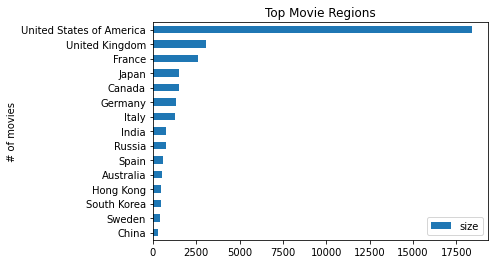

In [14]:
# Which regions do the movies come from most? 
MOVIES.groupby('Region').size().to_frame('size').sort_values('size', ascending=False).head(15).plot.barh(xlabel = '# of movies',
                                                                                                         title='Top Movie Regions').invert_yaxis()

In [15]:
MOVIES['Region'].unique()

array(['United States of America', 'Germany', 'United Kingdom', 'France',
       'Italy', 'China', 'Australia', 'South Africa', 'Canada', None,
       'Belgium', 'Iran', 'Netherlands', 'Hong Kong', 'Tunisia',
       'Dominican Republic', 'Croatia', 'Japan', 'Austria', 'Ireland',
       'Taiwan', 'New Zealand', 'Mexico', 'Peru', 'Cuba', 'Denmark',
       'Finland', 'Spain', 'Iceland', 'South Korea', 'Serbia', 'Sweden',
       'India', 'Argentina', 'Brazil', 'Senegal', 'Burkina Faso',
       'Hungary', 'Philippines', 'Czech Republic', 'Vietnam',
       'Switzerland', 'Trinidad and Tobago', 'Chile', 'Portugal',
       'Russia', 'Norway', 'Ukraine', 'Botswana', 'Aruba', 'Israel',
       'Luxembourg', 'Poland', 'Ecuador', 'Lebanon',
       'Bosnia and Herzegovina', 'Bahamas', 'Macedonia', 'Malaysia',
       'Bhutan', 'Bulgaria', 'Jamaica', 'Greece', 'Thailand', 'Namibia',
       'Cameroon', 'Colombia', 'Libyan Arab Jamahiriya', 'Algeria',
       'Turkey', 'Soviet Union', 'Slovenia', 'Afghan

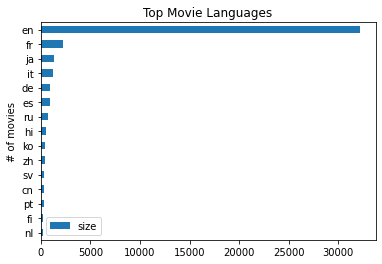

In [16]:
# Which languages are the movies mostly in? 
MOVIES.groupby('original_language').size().to_frame('size').sort_values('size', ascending=False).head(15).plot.barh(xlabel = '# of movies',
                                                                                                         title='Top Movie Languages').invert_yaxis()

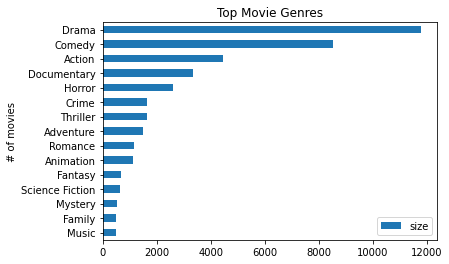

In [17]:
# Which genres are the movies mostly in? 
MOVIES.groupby('main_genre').size().to_frame('size').sort_values('size', ascending=False).head(15).plot.barh(xlabel = '# of movies',
                                                                                                         title='Top Movie Genres').invert_yaxis()

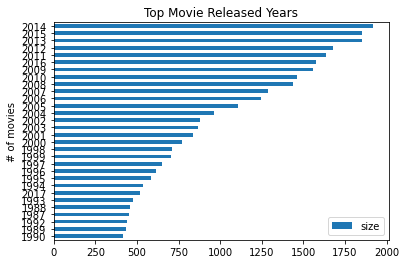

In [18]:
# Which years are the movies mostly released? 
MOVIES.groupby('release_date').size().to_frame('size').sort_values('size', ascending=False).head(30).plot.barh(xlabel = '# of movies',
                                                                                                         title='Top Movie Released Years').invert_yaxis()

<Axes: ylabel='Frequency'>

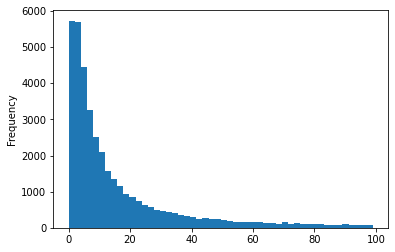

In [19]:
MOVIES[MOVIES['vote_count'] < 100]['vote_count'].plot.hist(bins=50)

# Prepare data for K-Means

In [20]:
MOVIES_kmeans = MOVIES.loc[(MOVIES.overview.str.len() > 50) & 
                           (MOVIES.original_language == 'en') & 
                           (MOVIES.Region == 'United States of America') & 
                           (MOVIES.release_date > 1990) &
                           (MOVIES.vote_count > 5), 
                      ['id', 'original_title', 'overview']]

In [21]:
MOVIES_kmeans.shape

(8230, 3)

In [22]:
MOVIES_kmeans.head()

,id,original_title,overview
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [23]:
MOVIES_kmeans.to_csv('./dataset/movies_processed.csv')

## Preprocess `overview`

In [135]:
# read stop words file
# stop word source: https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt

with open("./output/stopwords-en.txt", "r") as file:
  stopwords = [line.strip() for line in file]
stopwords = set(stopwords)
len(stopwords)

1298

In [136]:
## construct a vocabulary in overview of all movies 

vocab_counter = Counter()
def construct_vovabulary(text): 
    global vocab_counter
    text = set(re.sub("[^\w]", " ",  text).lower().split()).difference(stopwords)
    vocab_counter.update(Counter(text))
    return

In [137]:
%%capture
MOVIES_kmeans['overview'].apply(construct_vovabulary)

In [138]:
## filter out the words that only appears once

vocabulary = set([k for k, v in vocab_counter.items() if v > 1])
len(vocabulary)

13880

In [139]:
## save the vocabulary into a file for reuse

with open('./output/vocabulary.txt', 'w') as f:
    for item in list(vocabulary):
        f.write(f"{item}\n")

In [140]:
## read the vocabulary from the file  

vocabulary = set()
with open('./output/vocabulary.txt', 'r') as f:
    for line in f.readlines(): 
        vocabulary.add(line.strip('\n'))
len(vocabulary)

13880

## Text vectorization

In [141]:
## Vectorization: each row is an overview of a movie, each column is a word in the vocabulary, 
## the value represent the word frequency in one overview

n_row = MOVIES_kmeans.shape[0]
n_col = len(vocabulary)
vector = np.zeros((n_row, n_col), dtype = np.uint8)
for i, row in enumerate(MOVIES_kmeans['overview']): 
    # extract only words or numbers, but not symbols
    row = re.sub("[^\w]", " ",  row).lower()
    row_list = row.split(' ')
    row_dict = Counter(row_list)
    # only get the frequency of the words that are in the vocabulary
    for j, word in enumerate(vocabulary): 
        vector[i][j] = row_dict.get(word, 0)
    if i%100 == 0:
#         print(i)
        gc.collect()

In [142]:
vector.shape

(8230, 13880)

In [143]:
## save the text vector to a file

np.save('./output/text_vector', vector)

In [144]:
## read the text vector from a file

txt_vector = np.load('./output/text_vector.npy')
txt_vector.shape

(8230, 13880)

## Tf-idf

In [145]:
## word_num_col: word frequency of each word in all overviews (column-wise)

word_num_col = [len(np.nonzero(txt_vector[:, i])[0]) for i in range(txt_vector.shape[1])]
word_num_col = np.array(word_num_col, dtype=np.float32)
word_num_col.shape

(13880,)

In [146]:
## word_num_row: total word frequency in each overview (row-wise)

word_num_row = [np.sum(txt_vector[i, :]) for i in range(txt_vector.shape[0])]
word_num_row = np.array(word_num_row, dtype=np.float32)[..., np.newaxis]
word_num_row.shape

(8230, 1)

In [149]:
## idf: inverse document frequency matrix 
## a word is common or rare across all overviews 
## if a word is too common, then idf will be small to penalize the tf
idf = np.diag(np.log(txt_vector.shape[0] / word_num_col ))
idf.shape

(13880, 13880)

In [152]:
## tf: term frequency matrix
## the number of times that term t occurs in a movie's overview

tf=txt_vector / (word_num_row+0.01)
tf.shape

# tf=np.empty((txt_vector.shape[0], txt_vector.shape[1]))
# for i, row in enumerate(txt_vector):
#     row_word_num = row.sum()
#     tf[i] = row / (row_word_num + 0.01)

(8230, 13880)

In [153]:
## tfidf = tf * idf

tfidf = np.dot(tf, idf)
tfidf.shape

(8230, 13880)

In [154]:
## save the tfidf matrix to a file

np.save('./output/tfidf', tfidf)

## Create mapping between row number in the tfidf matrix and movie id 

In [155]:
MOVIES_kmeans.head()

,id,original_title,overview
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [160]:
movie_indexing = MOVIES_kmeans['id']

In [166]:
movie_indexing[MOVIES_kmeans['id'] == '8844'].index

Int64Index([1], dtype='int64')